# Logged Bandit Data

Often times we want to work with logged bandit data. Here we show how to use coba to... 

1. Generate logged bandit data
2. Evaluate/Learn policies from logged bandit data
4. Evaluate/Learn exploration from logged bandit data

In [1]:
import matplotlib.pyplot as plt

## Generate logged bandit data

Coba can generate logged bandit data in one of two ways: an environment filter or an experiment.

### Generate via filter

When generated via filter logged data is produced at request time using a logging policy (i.e., `RandomLearner` in the example below).

In [17]:
import coba as cb

envs = cb.Environments.from_linear_synthetic(1,n_actions=2,n_action_features=1,n_context_features=0)
lrn  = cb.RandomLearner()

list(envs.logged(cb.RandomLearner())[0].read())

[{'context': None,
  'actions': [[0.10673861019313335], [0.27717866748571396]],
  'rewards': DiscreteReward([[[0.10674], [0.27718]], [0.48749, 0.35408]]),
  'action': [0.10673861019313335],
  'reward': 0.48748829974177416,
  'probability': 0.5}]

### Generate via Experiment

The results of an Experiment can also be used to create logged bandit data.

In [15]:
import coba as cb

envs   = cb.Environments.from_linear_synthetic(1,n_actions=2,n_action_features=1,n_context_features=0)
lrn    = cb.RandomLearner()
result = cb.Experiment(envs,lrn,cb.SequentialCB(['context','actions','rewards','action','reward','probability'])).run(quiet=True)

list(cb.Environments.from_result(result)[0].read())

[{'action': [0.10674],
  'actions': [[0.10674], [0.27718]],
  'context': None,
  'probability': 0.5,
  'reward': 0.48749,
  'rewards': DiscreteReward([[[0.10674], [0.27718]], [0.48749, 0.35408]])}]

## Evaluate/Learn Policies From Logged Data

A common task when working with logged bandit feedback is to estimate how well a new policy would perform in the logged environment.

To perform off policy evaluation there are three common estimators used in the literature:

  1. Inverse Propensity Score (IPS) -- a higher-variance lower-bias estimator
  2. Direct Method (DM) -- a lower-variance higher-bias estimator
  3. Doubly Robust (DR) -- a lower-variance lower-bias estimator
  
We will evaluate all three of these methods against ground truth using 208 simulated datasets.


### 1. Create our evaluation data

To create our logged data we use a `MisguidedLearner`. This learner will behave very differently from the evaluation policies.

In [2]:
envs1 = cb.Environments.from_feurer().where(n_actions=(None,100)).reservoir(4_000,strict=True).scale(scale='minmax')
logs1 = envs1.logged(cb.MisguidedLearner(cb.VowpalEpsilonLearner(features=[1,'a','ax']),1,-1)).shuffle(n=20)

### 2. Define the experiment

In [3]:
evaluators  = [ cb.SequentialCB(learn='off',eval=eval) for eval in ['on','ips','dr','dm']]
experiment1 = cb.Experiment(logs1, cb.VowpalEpsilonLearner(features=[1,'a','ax']), evaluators )

### 3. Run the experiment

In [14]:
%%time
#WARNING: This can take some time to finish.
#WARNING: To simply see the results look below.
experiment1.run('out1.log.gz',processes=12,quiet=True)

CPU times: total: 40.6 s
Wall time: 3h 3min 55s
{'Learners': 1, 'Environments': 4940, 'Interactions': 37440000}


### 4. Analyze the results

We plot the experimental results to see which one of our three options best utilized the logged data to predict online performance.

In [2]:
result1 = cb.Result.from_file('out1.log.gz')

1.38
9.182
2.203


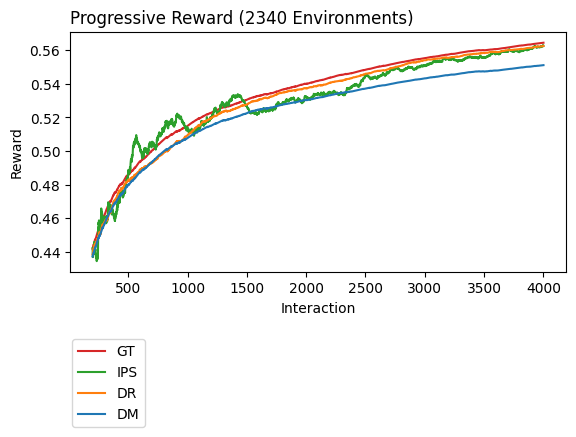

CPU times: total: 8.66 s
Wall time: 18.8 s


In [6]:
%%time
result1.plot_learners(xlim=(200,None),l='eval',p=['openml_task','shuffle_seed'],labels=['DM','DR','IPS','GT'])

In the plot above we can see how each of our reward estimators performed relative to the ground truth (GT). We know the ground truth  due to working with simulated data. In practice, when working with real world data, we won't know this value and will have to use a reward estimator such as DM, DR, or IPS instead.

Based on the plot above it appears that DM estimates GT most poorly while DR estimates it best. This is not the full story though because what is plotted above is the average over all of our data sets and so it can hide extreme errors. By hidden extremes what we mean is this, imagine two people are trying to estimate the height of a 5' tall person. We will call our two people estimators. The first estimator guesses the person is 3' tall and 7' tall while the second estimator guesses the person is 4'11" and 5'1" tall. Now both of these people were correct on average (i.e., for both estimators their average estimate was 5' which was the ground truth) but one of them we could argue was a better estimator because not only were they right on average but their estimates were also close to the ground truth. This is what we mean by hidden extremes. To look for this we create a contrast plot.

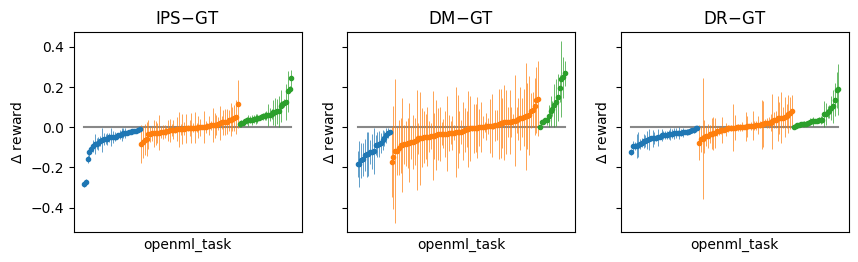

In [5]:
f,ax = plt.subplots(ncols=3,sharey=True,figsize=(10,4))

result1.plot_contrast('on','ips',x='openml_task',l='eval',err='sd',ax=ax[0],xticks=False,legend=False,out=None)
result1.plot_contrast('on','dm' ,x='openml_task',l='eval',err='sd',ax=ax[1],xticks=False,legend=False,out=None)
result1.plot_contrast('on','dr' ,x='openml_task',l='eval',err='sd',ax=ax[2],xticks=False,legend=False,out=None)

for a,title in zip(ax,['IPS$-$GT','DM$-$GT','DR$-$GT']):
    a.set_title('',loc='left')
    a.set_title(title,loc='center')
    a.set_xticks([])

plt.show()

The plot above shows the difference between the IPS, DM, and DR estimator relative to GT on all of our datasets. This is the distribution of estimates that are being averaged over in the the first plot. Here we can see that the DR estimator has a very similar pattern to the DM estimator but with smaller extremes. More specifically, the DR error ranges from approximately -0.1 to 0.2 while the DM error ranges from -0.2 to 0.3. We can show this same result as the variance of the mean.

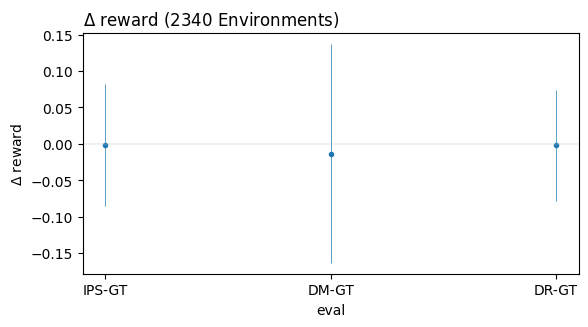

In [7]:
result1.plot_contrast('on',['ips','dm','dr'],x='eval',l='eval',err='sd',boundary=False,legend=False,out=None)
plt.axhline(0,color="#BBB",alpha=.2)
plt.xticks([0,1,2],['IPS-GT','DM-GT','DR-GT'])
plt.show()

The plot above shows a point estimate for difference from ground truth for each of our estimators at the 4,000th interaction. That is, each point in this plot is equal to the difference between each estimator and ground truth in the first figure. The blue lines shows standard deviation of the estimates making up each point. We can see that the standard deviation for the DM-GT errors is much larger than the standard deviation for IPS-GT error. This might seem counter-intuitive but it is a consequence of reporting the mean for all 4,000 rewards. We can see this more clearly below.

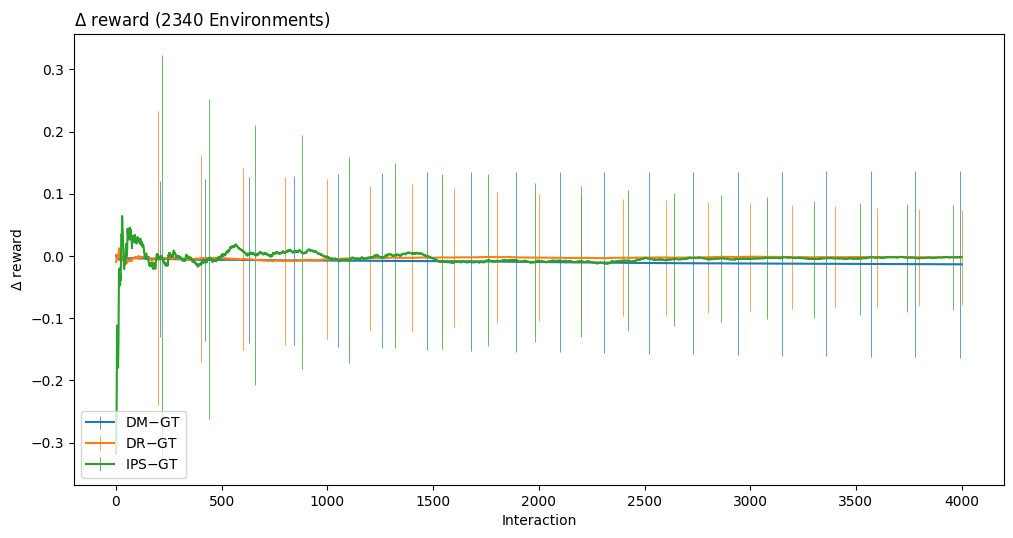

In [12]:
plt.figure(figsize=(12,9))
result1.plot_contrast('on','dm' ,x='index',l='eval',colors=0,err='sd',errevery=210,boundary=False,out=None,labels=['DM$-$GT' ])
result1.plot_contrast('on','dr' ,x='index',l='eval',colors=1,err='sd',errevery=200,boundary=False,out=None,labels=['DR$-$GT' ])
result1.plot_contrast('on','ips',x='index',l='eval',colors=2,err='sd',errevery=220,boundary=False,out=None,labels=['IPS$-$GT'])
plt.legend(loc='lower left', bbox_to_anchor=(0,0))
plt.show()

The plot above shows the average difference between ground truth and DM/DR/IPS. We can see that while the variance of the DR/IPS estimators start out very large it eventually becomes smaller than DM around interaction 2,000 due to us averaging 2,000 observations. On the other hand the DM estimator stays consistent as the estimator is consistently right or wrong throughout all 4,000 interactions.

---

## Evaluate/Learn Exploration From Logged Data

Our goal is to use logged data to estimate online exploration performance.

To do this we have three options:
  1. Perform on-policy evaluation using a reward estimator
  2. Perform off-policy evaluation using the logged data
  3. Use rejection sampling to make the logged data look like the desired exploration
  
We will evaluate all three options using logged data that we generate from a large set of classification datasets. By conducting this experiment over many datasets we can get a sense of the expected performance for each method independent of any one dataset. We will also intentionally use a misguided logging policy to generate our data to ensure that the logging policy doesn't look anything like the policies we wish to estimate.  

### 1. Create evaluation data
To create our logged data we use a `MisguidedLearner`. This learner behaves very differently from the policies we want to evaluate.

In [2]:
envs2 = cb.Environments.from_feurer().reservoir(30_000,strict=True).scale(scale='minmax')
logs2 = envs2.logged(cb.MisguidedLearner(cb.VowpalEpsilonLearner(epsilon=.5,features=[1,'a','ax']),1,-1)).shuffle()

### 2. Define the experiment 

In [3]:
experiment2 = cb.Experiment(logs2, cb.VowpalEpsilonLearner(features=[1,'a','ax']), [
    cb.SequentialCB(learn='on' ,eval='on'), #GT
    cb.SequentialCB(learn='dr' ,eval='dr'), #on-policy learning from dr reward estimate (option 1)
    cb.SequentialCB(learn='off',eval='dr'), #off-policy learning (option 2)
    cb.RejectionCB ()                       #rejection-sampling (option 3)
])

### 3. Run the experiment

In [ ]:
%%time
#WARNING: This can take some time to finish.
#WARNING: To simply see the results look below.
experiment2.run('out2.log.gz',processes=4,quiet=True)

### 4. Analyze the results

We plot the experimental results to see which one of our three options best utilized the logged data to predict online performance.

In [40]:
result2 = cb.Result.from_save('out2.log.gz')

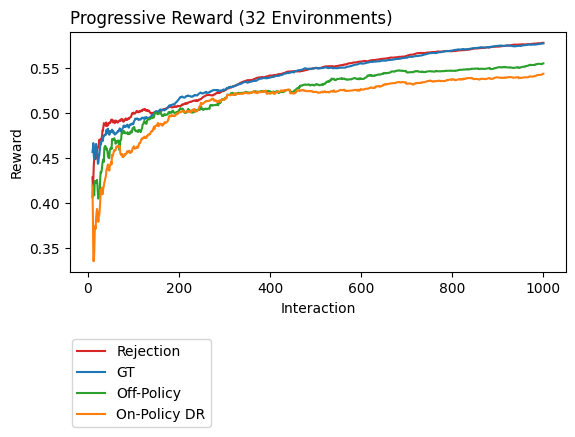

In [88]:
labels=['third option','second option','first option','ground truth']
result2.filter_fin(1000,l='evaluator_id',p='environment_id').plot_learners(xlim=(10,None),l='evaluator_id',p='environment_id',labels=['GT','On-Policy DR','Off-Policy','Rejection'])

In this plot the third option, rejection, looks pretty good. It almost perfectly matches the average online performance across 32 unique classification datasets. Unfortunately, this plot isn't the full story. To get this accuracy we had to sacrafice some data. Notice that the plot above only has 1,000 interactions but our original dataset had 30,000 examples.

We now create a plot that shows the all 30,000 examples so we can see how much data was thrown out when using the `RejectionCB`.

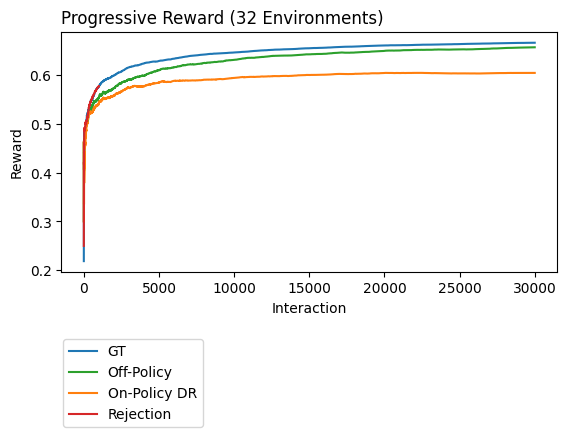

In [84]:
eid = set(result2.filter_fin(1000).filter_fin(l='evaluator_id',p='openml_task').environments['environment_id'])

result2\
    .where(environment_id=eid)\
    .where(eval_type={'!=':'RejectionCB'})\
    .plot_learners(l='evaluator_id',p='openml_task',colors=[0,1,2],labels=['GT','On-Policy DR','Off-Policy'],out=None)

result2\
    .where(environment_id=eid)\
    .where(eval_type={'=':'RejectionCB'})\
    .filter_fin(1000,'evaluator_id','openml_task')\
    .plot_learners(l='evaluator_id',p='openml_task',labels='Rejection',colors=3)